<a href="https://colab.research.google.com/github/mjg-phys/cdm-computing-subgroup/blob/main/mini-workshops/CDM_Monte_Carlo_methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CDM Computing mini-workshop: Monte Carlo methods

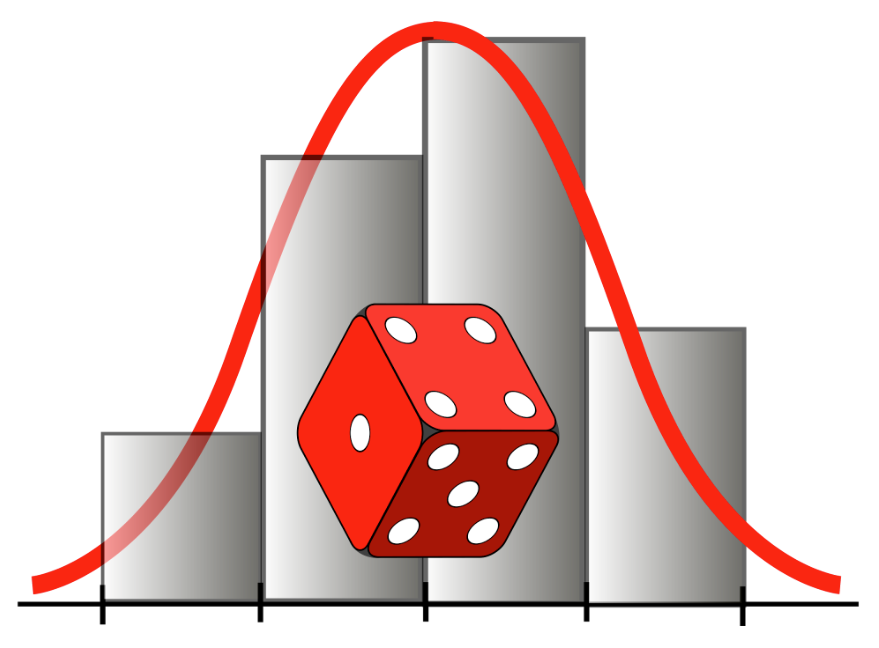


# Import packages

In [ ]:
import numpy as np
from numpy import random

from scipy.interpolate import interp1d
from scipy.integrate import quad,solve_ivp
from scipy.special import erf, erfc
from scipy.optimize import minimize, root
from scipy.stats import norm, poisson

import matplotlib as mpl
import matplotlib.pyplot as plt

from mpl_toolkits.axes_grid1 import make_axes_locatable

from google.colab import files

# Introduction

- Monte Carlo methods use random numbers (or pseudo-random) to produce numerical results

- Monte Carlo techniques were pioneered by physicists Fermi and Ulum, in the 1940s (named by Ulum after the Monte Carlo casino where his uncle gambled)

- Three main classes of problems:
  - random samples from distributions,
  - optimisation
  - integration

- As you've probably already encountered, these are used extensively in particle physics

## Simple uniform random number generator

Real random number generation is possible, but requires dedicated hardware (or internet connection e.g. random.org). Instead we generally use pseudo-random numbers, which are drawn from a completely deterministic chain.

**Example**

This is a linear congruential generator:

$X_{n+1} = (a X_n + c)\,\rm{mod}\, m$

The choices of a, c and m are very important (see [wiki](https://en.wikipedia.org/wiki/Linear_congruential_generator) for a list of useful parameter choices). Particular choices will ensure the period is long and that it approximates the properties of a truly uniform random distribution, i.e. tends towards

$p(x) = \frac{1}{x_{\rm{max}} - x_{\rm{min}}}$

This is a fast and easy to implement generator - but can have problems when used for higher dimensional simlations.

Pseudo-random number generators require a seed (somewhere to start). This is useful because we can have deterministic behavior. In practice you probably want to take the seed from something like the system clock.

The one below creates a pseudo-random integer of length 2**31.:

In [ ]:
# Initialize a seed value.
seed = 12345

def generate_random_number():
  """Generates a random number between 0 and 1."""
  seed = globals()['seed']

  # Calculate the next random number using the linear congruential generator.
  seed = (1103515245 * seed + 12345) % 2**31
  globals()['seed'] += 1
  # Return the random number as a float between 0 and 1.
  return seed / 2**31

In [ ]:
# Generate and print a single random number.
random_number = generate_random_number()
print(random_number)

0.6551540484651923


Let's generate a large sample and produce a histogram to see that this is working.

In [ ]:
random_vals = np.array([ generate_random_number() for i in range(10000)])

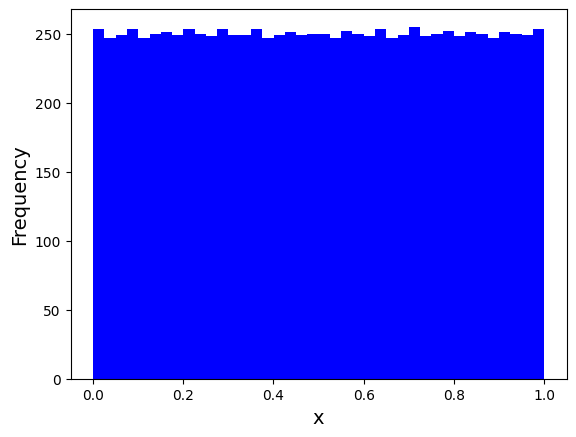

In [ ]:
#Specify number of bins
bins = 40

# Plot the histogram
plt.hist(random_vals, bins, color='blue', histtype='bar')

# Add labels and title
plt.xlabel(r"x", fontsize=14)
plt.ylabel(r"Frequency", fontsize=14)

# Display the plot
plt.show()

Check the mean tends to the expected value:

$<x> = \int x p(x) dx = (x_{\rm{max}} - x_{\rm{min}})/2 = 1/2$

In [ ]:
np.mean(random_vals)

0.5001339653167873

In practice most of the time just use the built-in numpy generator (which uses a [Mersenne twister](https://en.wikipedia.org/wiki/Mersenne_Twister))

In [ ]:
np.random.uniform(0, 1, size = 10)

array([0.34147044, 0.47225246, 0.0859406 , 0.27459063, 0.01828422,
       0.31752458, 0.84410064, 0.39856628, 0.28460598, 0.61144279])

See also numpy's more recent implementation with a generator object.

## Calculate $\pi$ from random numbers




The ratio of the area of the unit circle and the square that bounds it is:

$A_c / A_s = \pi/4$

If we 'throw' random points at the (x,y) plane we should find the same ratio inside a circle.

In [ ]:
num_points_inSquare = 10000

#Generate points in x,y between -1 and 1 (to cover the unit circle)
x_vals = np.random.uniform( -1.0, 1.0, size=num_points_inSquare)
y_vals = np.random.uniform( -1.0, 1.0, size=num_points_inSquare)

Plot our random points and show the cirle:

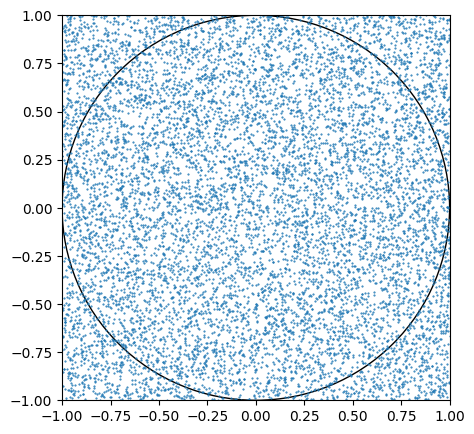

In [ ]:
fig1, ax = plt.subplots(figsize=(5,5))
plt.plot(x_vals, y_vals,marker='o',markersize=.5,linestyle='')

circle = mpl.patches.Circle((0,0),1,fill=False,edgecolor='black')
ax.add_patch(circle)

plt.ylim(-1,1)
plt.xlim(-1,1)

plt.show()

How many of these points lie within the unit circle?

In [ ]:
num_points_inCircle = 0

for i in range(num_points_inSquare):
  if np.sqrt(x_vals[i]**2 + y_vals[i]**2) < 1:
    num_points_inCircle += 1

print(num_points_inCircle)

7799


Now calculate our estimate for $\pi$:

In [ ]:
ourPi = num_points_inCircle/num_points_inSquare * 4

print(ourPi)

3.1196


**Exercise**

Write a function (in a more pythonic way) to calculate the value of $\pi$ using the above method for a given number of points.

Make a plot to illustrate convergence with increasing number of points.

In [ ]:
#SOLUTION

# This function returns an approximation to pi using numPoints uniform
# random numbers thrown at the unit squaure
def pi_approx(numPoints):

    numPointsInCircle = 0

    #generate random points
    x_vals = np.random.uniform( 0.0, 1.0, size=numPoints)
    y_vals = np.random.uniform( 0.0, 1.0, size=numPoints)

    #count number within the unit circle
    for i in range(numPoints):
      if np.sqrt(x_vals[i]**2 + y_vals[i]**2) < 1:
        numPointsInCircle += 1

    #calcuate and return approximate value of pi
    return numPointsInCircle/numPoints * 4.

#make the function callable with an array
pi_approx = np.frompyfunc(pi_approx, 1, 1)

In [ ]:
#Do the calculation for a range of values for numPoints
n_vals = 10**np.array([0,1,2,3,4,5,6,7])
pi_vals = pi_approx(n_vals)

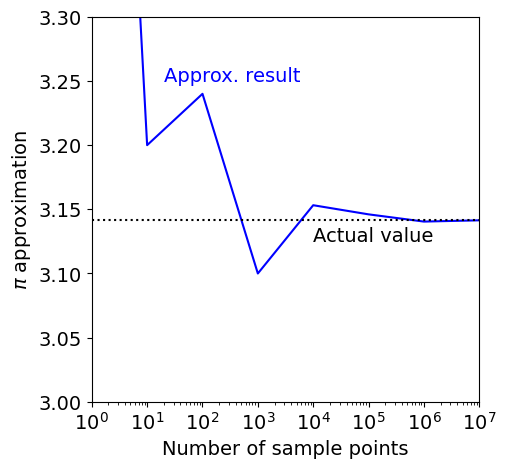

In [ ]:
#Plot our pi approximation as function of numPoints
fig1 = plt.figure(figsize=(5,5))
plt.plot(n_vals, pi_vals, 'b-',\
         n_vals, list(np.pi for n in n_vals), 'k:')

plt.xscale('log')

plt.xlabel(r"Number of sample points",fontsize=14)
plt.ylabel(r"$\pi$ approximation",fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.ylim(3,3.3)
plt.xlim(1,1e7)

#Add text to label curve
plt.text(1e4,3.125,r"Actual value",fontsize=14)
plt.text(20,3.25,r"Approx. result",fontsize=14, color='blue')
plt.show()

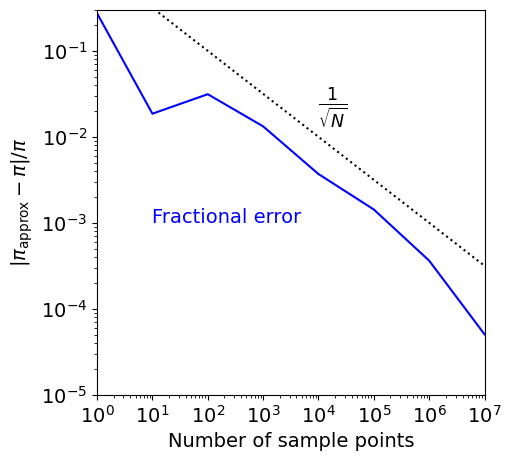

In [ ]:
#Or plot the fractional error in our result as function of numPoints

fig1 = plt.figure(figsize=(5,5))
plt.plot(n_vals, np.abs(pi_vals-np.pi)/np.pi, 'b-',
         n_vals, list(1/np.sqrt(n) for n in n_vals), 'k:')

plt.yscale('log')
plt.xscale('log')

plt.xlabel(r"Number of sample points",fontsize=14)
plt.ylabel(r"$\vert\pi_{\rm{approx}}-\pi\vert/\pi$",fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.ylim(1e-5,.3)
plt.xlim(1,1e7)

#Add text to label curve
plt.text(10,1e-3,r"Fractional error",fontsize=14, color='blue')
plt.text(1e4,2e-2,r"$\frac{1}{\sqrt{N}}$",fontsize=18)
plt.show()

But why?

For a given N, let's look at the distribution of approximated $\pi$ values:



In [ ]:
N = 1000
pi_val_dist = [pi_approx(N) for i in range(1,10000)]

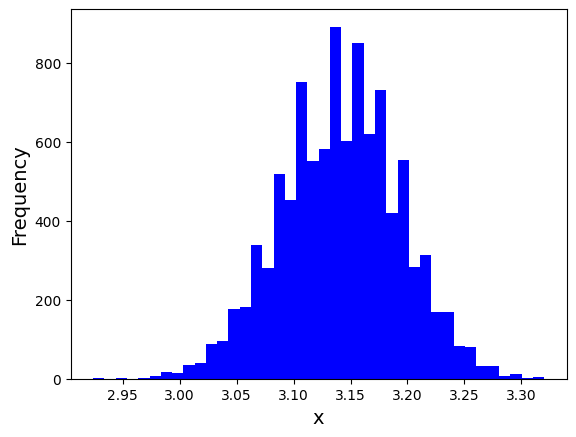

In [ ]:
#Specify number of bins
bins = 40

# Plot the histogram
plt.hist(pi_val_dist, bins, color='blue', histtype='bar')

# Add labels and title
plt.xlabel(r"x", fontsize=14)
plt.ylabel(r"Frequency", fontsize=14)

# Display the plot
plt.show()

This looks a lot like a normal distribution --> because it is, by the [central limit theorem.](https://en.wikipedia.org/wiki/Central_limit_theorem)

The CLT states that a sample distribution will have a standard deviation $\propto 1/\sqrt{N}$.

#Sampling from distributions



A common application for Monte Carlo simulations is drawing random numbers from non-uniform distributions.

Above we used random points between 0 and 1 -> we can use these and transform into many different distributions.

###"Guess and check"

Similar to our $\pi$ calculation, in this method we throw random points at a region and only keep those below the curve.

This is straightforward, but not very efficient for many functions (especially in higher dimensions).


**Example: the normal distribution**

We will write code to generate random samples from the standard normal distribution with $\mu=0, \sigma=1$.

Start by generating some random points that bound (most) of the distribution:

In [ ]:
numPoints = 1000

#Generate some random points
x_rnd_vals = np.random.uniform( -5.0, 5.0, size=numPoints)
y_rnd_vals = np.random.uniform( 0., 0.5, size=numPoints)

#stack the two sets of random numbers to create (x,y) pairs
rnd_vals_2D = np.column_stack((x_rnd_vals,y_rnd_vals))

Visualise the points with our distribution:

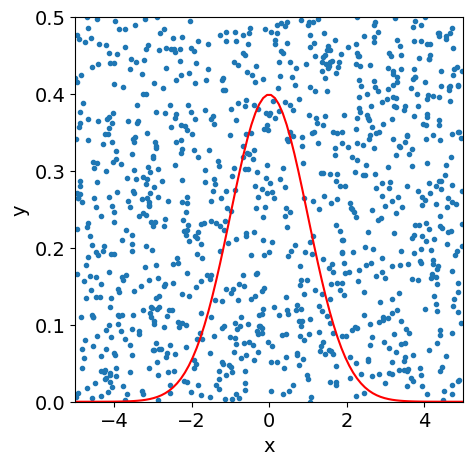

In [ ]:
x_pdf_vals = np.linspace(-5,5,100)
y_pdf_vals = norm.pdf(x_pdf_vals)

fig1 = plt.figure(figsize=(5,5))
plt.plot(x_pdf_vals, y_pdf_vals, 'r-')
plt.scatter(rnd_vals_2D[:,0], rnd_vals_2D[:,1], marker='.')

plt.xlabel(r"x",fontsize=14)
plt.ylabel(r"y",fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.ylim(0,.5)
plt.xlim(-5,5)

plt.show()

Throw out the points above the curve:

In [ ]:
normDist_samples = np.empty([0, 2])

#loop over the array of points and add points that pass the test to a new array
for point in rnd_vals_2D:
    if( point[1] < norm.pdf(point[0])):
        normDist_samples = np.append( normDist_samples, [point], 0)

Re-plot to check it's working and create a histogram:

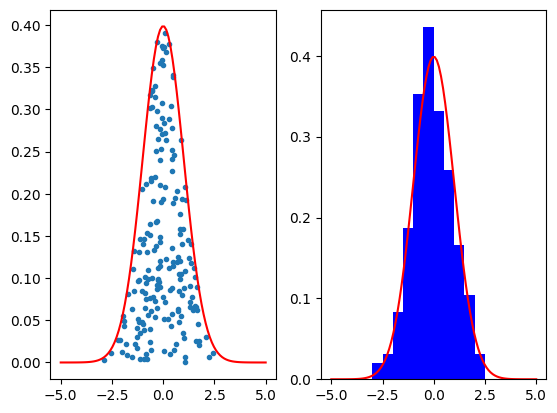

<Figure size 500x500 with 0 Axes>

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)

#plot
fig1 = plt.figure(figsize=(5,5))
ax1.plot( x_pdf_vals, y_pdf_vals, 'r-')
ax1.scatter( normDist_samples[:,0], normDist_samples[:,1], marker='.')

#plot histogram
ax2.plot( x_pdf_vals, y_pdf_vals, 'r-')
ax2.hist(normDist_samples[:,0], 20, (-5,5), color='blue', density=True, histtype='bar')

plt.show()

So after generating a bunch of points we only kept a small fraction, we will do better in the next section.

In [ ]:
#Efficiency:
normDist_samples.size/rnd_vals_2D.size

0.193

**Exercise**

Using this method write a function which returns N samples from a supplied distribution f(x) in a range x_min to x_max.

To improve efficiency you can optionally include an argument for the  maximum y value.

In [ ]:
#SOLUTION

def random_func_samples(func, x_min, x_max, numPoints, y_max=float("nan")):

  x_rnd_vals = np.random.uniform( x_min, x_max, size=numPoints)
  func_vals  = func(x_rnd_vals)

  y_max = np.max(func_vals)
  y_min = np.min(func_vals)

  y_rnd_vals = np.random.uniform( y_min, y_max, size=numPoints)

  samples = []
  #loop over the array of points and add points that pass the test to a new array
  for i in range(1,numPoints):
    if(y_rnd_vals[i] < func_vals[i]):
      samples = np.append( samples, [x_rnd_vals[i]], 0)

  return samples

In [ ]:
def test_func(x):
    return norm.pdf(x)
normSamples = random_func_samples(test_func, -5, 5, 10000)


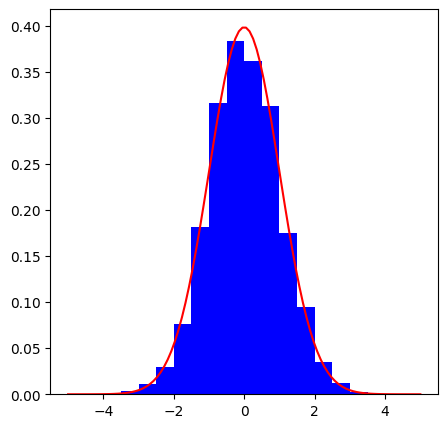

In [ ]:
#plot
fig1 = plt.figure(figsize=(5,5))

#plot histogram
plt.hist(normSamples, 20, (-5,5), color='blue', density=True, histtype='bar')
plt.plot(x_pdf_vals, y_pdf_vals, 'r-')

plt.show()

###Inverse transform sampling

What if we could simply throw random numbers into exactly the shape of the distribution?

We can, by stretching/compressing the uniform distribution in just the right way. For a distribution p(x), this is achieved by applying the inverse CDF, $P^{-1}(x)$, to the uniform distribution.

**Example: normal distribution**

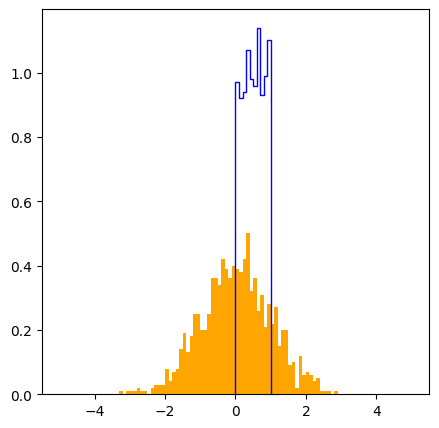

In [ ]:
numPoints=1000

#Create uniform samples
x_rnd_uniform_vals = np.random.uniform( 0., 1.0, size=numPoints)

#Feed them into the normal CDF
x_rnd_normal_vals = norm.ppf(x_rnd_uniform_vals)

#Plot the result
fig1 = plt.figure(figsize=(5,5))
plt.hist(x_rnd_normal_vals, 100, (-5,5), color='orange', density=True, histtype='bar')
plt.hist(x_rnd_uniform_vals, 10, (0,1), color='blue', density=True, histtype='step')

plt.show()

To visualise this, plot the CDF:

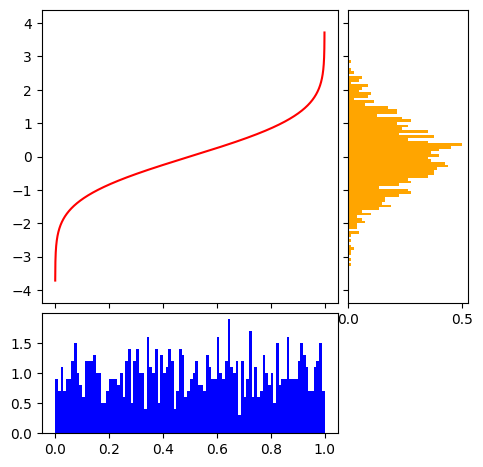

In [ ]:
x_invcdf_vals = np.linspace(0,1,10000)
y_invcdf_vals = norm.ppf(x_invcdf_vals)

fig, ax = plt.subplots(figsize=(5.5, 5.5))

# the scatter plot:
ax.plot(x_invcdf_vals, y_invcdf_vals, 'r-')

# Set aspect of the main axes.
#ax.set_aspect(1.)

# create new axes on the right and on the top of the current axes
divider = make_axes_locatable(ax)
# below height and pad are in inches
ax_histx = divider.append_axes("bottom", 1.2, pad=0.1, sharex=ax)
ax_histy = divider.append_axes("right", 1.2, pad=0.1, sharey=ax)

ax_histx.hist(x_rnd_uniform_vals, 100, (0,1), color='blue', density=True, histtype='bar')
ax_histy.hist(x_rnd_normal_vals, 100, (-4,4), color='orange', density=True, histtype='bar',orientation=u'horizontal')

#ax_histx.xaxis.set_tick_params(labelbottom=False)
ax_histy.yaxis.set_tick_params(labelleft=False)

plt.show()

Of course numpy already has random number generators for most common distributions (see
https://numpy.org/doc/stable/reference/random/generator.html)

**Exercise**

Now write a class that will create the inverse CDF of a given function and produce random samples

In [ ]:
#SOLUTION

class inverse_transform_generator:
    def __init__(self, func, x_min, x_max, numPoints=100):
        self.x_min = x_min
        self.x_max = x_max

        #evaluate func on grid of x values
        x_vals = np.linspace(x_min, x_max, numPoints)
        y_vals = func(x_vals)

        #integrate from x_min to x (compute CDF)
        #for i in range(0,numPoints):
        #    cdf_vals = np.trapz(y_vals[:i], x_vals[:i])
        cdf_vals = [np.trapz(y_vals[:i], x_vals[:i]) for i in range(0,numPoints)]
        #ensure func in normalised
        cdf_vals /= cdf_vals[-1]
        self.invFunc = interp1d( cdf_vals, x_vals, fill_value=( 0, 1), bounds_error=False)

    def get_samples(self, numPoints=1):
        return self.invFunc(np.random.uniform( 0, 1, size=numPoints))

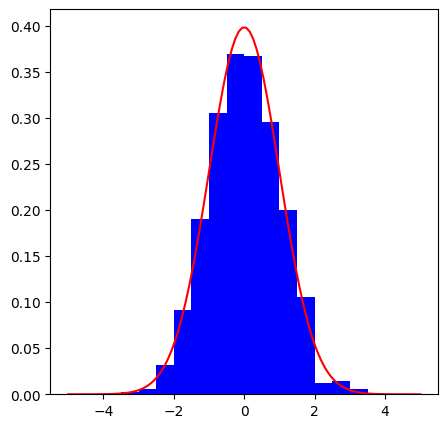

In [ ]:
#EXAMPLE

#Create generator object using our previous test function
my_random_normal = inverse_transform_generator(test_func, -5, 5, 1000)

#Generate some samples
normSamples = my_random_normal.get_samples(1000)

#plot
fig1 = plt.figure(figsize=(5,5))

#plot histogram
plt.hist(normSamples, 20, (-5,5), color='blue', density=True, histtype='bar')
plt.plot(x_pdf_vals, y_pdf_vals, 'r-')

plt.show()

## Markov-chain Monte Carlo (MCMC)

Inverse transform sampling works for 1D distributions, in higher dimensions we would have to revert to guess-and-check, which becomes very inefficient.

In this section we will use the Metropolis-Hastings algorithm to sample from a multi-dimensional distribution

It is a type Markov-Chain (process with a series of steps which depend on the previous step) Monte Carlo method.

Let's start by making a simple Markov-Chain which performs a random walk.

We will begin at the point $s_0 = (0,0)$ and take a random step in the x and y directions, drawn from a normal distribution.

In [ ]:
#define number of steps to take
num_steps = 100

#create an array to store the steps
steps = np.empty([num_steps, 2])

#Set the starting position
steps[0] = [0,0]

#Define the step size (as the std dev of a normal dist.)
step_size = .5

#loop over the array of points and add points that pass to a new array
for i in range(1,num_steps):
    steps[i] = steps[i-1] + random.normal( 0, step_size, 2)

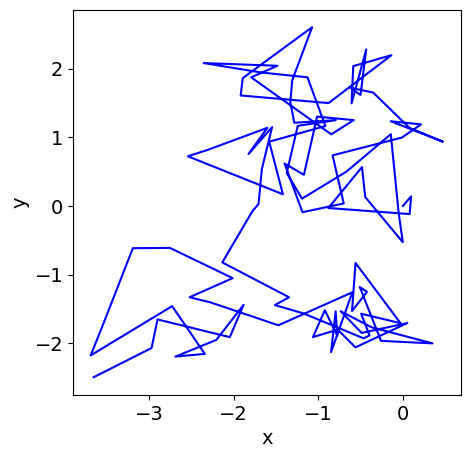

In [ ]:
#Plot our Markov chain
fig1 = plt.figure(figsize=(5,5))
plt.plot(steps[:,0], steps[:,1], 'b-')

plt.xlabel(r"x",fontsize=14)
plt.ylabel(r"y",fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.show()

Now let's do a longer one, constrain it to a box with periodic boundary conditions, and plot a histogram of x and y values:

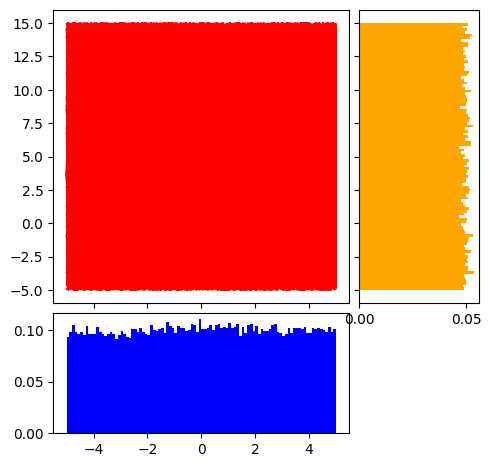

In [ ]:
num_steps = 100000
steps = np.empty([num_steps, 2])
steps[0] = [0,0]

#Step size and bounding box
step_size = 1
x_max = y_max = 5
x_min = y_min = -5

#loop over the array of points and add points that pass to a new array
for i in range(1,num_steps):

    rnd_step = steps[i-1] + random.normal( 0, step_size, 2)
    if rnd_step[0] > x_max:
      rnd_step[0] -= x_max - x_min
    elif rnd_step[0] < x_min:
      rnd_step[0] += x_max - x_min
    if rnd_step[1] > y_max:
      rnd_step[1] -= y_max - y_min
    elif rnd_step[1] < x_max:
      rnd_step[1] += y_max - y_min
    steps[i] =  rnd_step

#Plot
fig, ax = plt.subplots(figsize=(5.5, 5.5))

# the scatter plot:
ax.plot(steps[:,0], steps[:,1], 'r-')

# Set aspect of the main axes.
#ax.set_aspect(1.)

# create new axes on the right and on the top of the current axes
divider = make_axes_locatable(ax)
# below height and pad are in inches
ax_histx = divider.append_axes("bottom", 1.2, pad=0.1, sharex=ax)
ax_histy = divider.append_axes("right", 1.2, pad=0.1, sharey=ax)

ax_histx.hist(steps[:,0], 100, color='blue', density=True, histtype='bar')
ax_histy.hist(steps[:,1], 100, color='orange', density=True, histtype='bar',orientation=u'horizontal')

#ax_histx.xaxis.set_tick_params(labelbottom=False)
ax_histy.yaxis.set_tick_params(labelleft=False)

plt.show()

In the above we introduced a conditional step to the Markov-Chain, only keeping the next point if it was within our box. This is essentially already sampling a 2D distribution - a uniform one.

While, on the whole, we are sampling a distribution, nearby steps are correlated. Typically you need more samples to average over this effect.


To sample from an arbitrary distribution, f(s), we need to tie the likelihood of keeping a given step to the distribution f(s). The Metropolis-Hastings algorithm does this with the simple accept/reject step:

If $f(s_i)/f(s_{i-1}) > u $, then keep $s_i$

Where $u$ is a unit uniform random number.

**Example**

Lets sample a 2D normal distribution (with no covariance) with the Metropolis-Hastings algorithm.

**Uniform vs. normal dist stepping**

Last week someone asked about this. The problem with the below uniform stepping is that, in 2D, you preference certain directions. Whether this affects the distribution depends on step size. I've set up a 'step' below so you can change it and check for yourself.

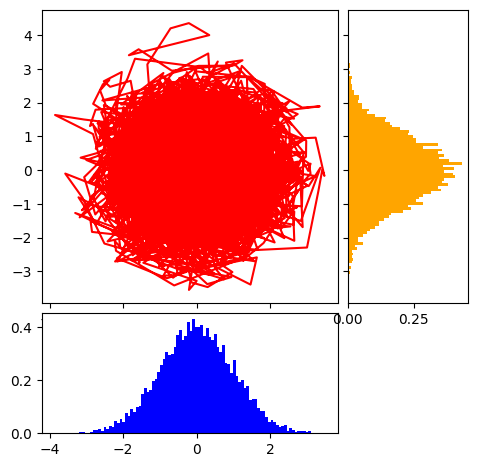

In [ ]:
num_steps = 10000
steps = np.empty([num_steps, 2])
steps[0] = [0,0]

#Step size
step_size = 0.5

#define our 2D distribution
def f( point2D):
    return norm.pdf(point2D[0]) * norm.pdf(point2D[1])

def step():
    #return random.uniform( -step_size, step_size, 2)
    return random.normal(0, 1, 2)

#take num_steps random steps
for i in range(1,num_steps):

    rnd_step = steps[i-1] + step()
    while f(rnd_step)/f(steps[i-1]) < random.uniform(0,1):
        rnd_step = steps[i-1] + step()
    steps[i] =  rnd_step

#Plot
fig, ax = plt.subplots(figsize=(5.5, 5.5))

# the scatter plot:
ax.plot(steps[:,0], steps[:,1], 'r-')

# Set aspect of the main axes.
#ax.set_aspect(1.)

# create new axes on the right and on the top of the current axes
divider = make_axes_locatable(ax)
# below height and pad are in inches
ax_histx = divider.append_axes("bottom", 1.2, pad=0.1, sharex=ax)
ax_histy = divider.append_axes("right", 1.2, pad=0.1, sharey=ax)

ax_histx.hist(steps[:,0], 100, color='blue', density=True, histtype='bar')
ax_histy.hist(steps[:,1], 100, color='orange', density=True, histtype='bar',orientation=u'horizontal')

#ax_histx.xaxis.set_tick_params(labelbottom=False)
ax_histy.yaxis.set_tick_params(labelleft=False)

plt.show()

The above is a rather simple example, in higher dimensions and where you don't start at the maxima there will normally be a series of steps at the start which don't follow the distribution. In this case it is typical to 'burn-in' the Markov-Chain i.e. you throw away some number of initial steps.

We also glossed over the choice of step size and its distribution - these (and amount of burn-in) need to be chosen case-by-case, checking that the results you get match expectations.

**Exercise**

(i) Check that the above follow the correct (normal) distributions.

(ii) Implement Metropolis-Hastings on a 3D multivariate normal distribution

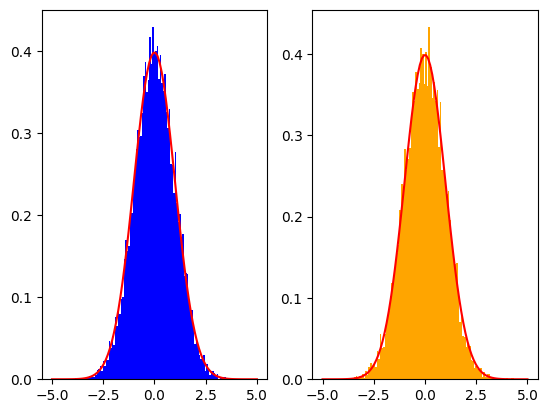

<Figure size 500x500 with 0 Axes>

In [ ]:
#SOLUTION (i)

x_vals = np.linspace(-5,5,100)
x_pdf_vals = norm.pdf(x_vals)
y_vals = np.linspace(-5,5,100)
y_pdf_vals = norm.pdf(y_vals)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig1 = plt.figure(figsize=(5,5))

#plot x histogram
ax1.plot(x_vals, x_pdf_vals, 'r-')
ax1.hist(steps[:,0], 100, color='blue', density=True, histtype='bar')

#plot y histogram
ax2.plot(y_vals, y_pdf_vals, 'r-')
ax2.hist(steps[:,1], 100, color='orange', density=True, histtype='bar')

plt.show()

The above is a check "by eye", but we can also check the moments and standard dev (since we know the dist. is independent, this is easy):

In [ ]:
x_mean = np.mean(steps[:,0])
x_std = np.std(steps[:,0])

y_mean = np.mean(steps[:,1])
y_std = np.std(steps[:,1])

printx = "x: mean = {:.2f}, std. dev. = {:.2f}"
print(printx.format(x_mean, x_std))

printy = "y: mean = {:.2f}, std. dev. = {:.2f}"
print(printy.format(y_mean, y_std))


x: mean = 0.01, std. dev. = 1.00
y: mean = -0.01, std. dev. = 1.00


In [ ]:
#SOLUTION (ii)
from scipy.stats import multivariate_normal

num_steps = 10000
steps = np.empty([num_steps, 3])
steps[0] = [0,0,0]

#Step size
step_size = 0.5

#define our 3D multivariate normal dist
dist_means = [5, 10, -2]
dist_cov   = [[1,-.5,-.2], [-.5,1,.5], [-.2,.5,1]]
def f(point3D):
    return multivariate_normal.pdf( point3D, mean=dist_means, cov=dist_cov)

def step():
    #return random.uniform( -step_size, step_size, 3)
    return random.normal(0, 1, 3)

#take num_steps random steps
for i in range(1,num_steps):

    rnd_step = steps[i-1] + step()
    while f(rnd_step)/f(steps[i-1]) < random.uniform(0,1):
        rnd_step = steps[i-1] + step()
    steps[i] =  rnd_step


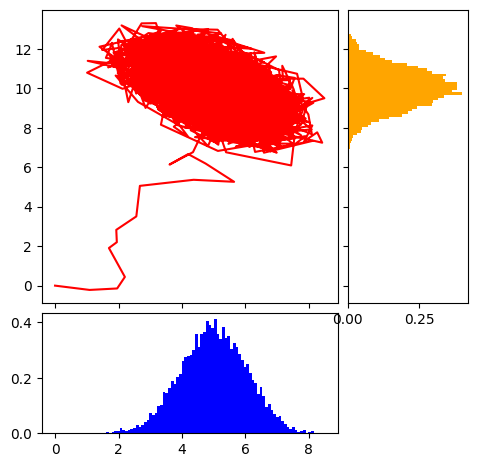

In [ ]:
fig, ax = plt.subplots(figsize=(5.5, 5.5))

# the scatter plot:
ax.plot(steps[:,0], steps[:,1], 'r-')

# Set aspect of the main axes.
#ax.set_aspect(1.)

# create new axes on the right and on the top of the current axes
divider = make_axes_locatable(ax)
# below height and pad are in inches
ax_histx = divider.append_axes("bottom", 1.2, pad=0.1, sharex=ax)
ax_histy = divider.append_axes("right", 1.2, pad=0.1, sharey=ax)

ax_histx.hist(steps[:,0], 100, color='blue', density=True, histtype='bar')
ax_histy.hist(steps[:,1], 100, color='orange', density=True, histtype='bar',orientation=u'horizontal')

#ax_histx.xaxis.set_tick_params(labelbottom=False)
ax_histy.yaxis.set_tick_params(labelleft=False)

plt.show()

## Poisson

We can also generate numbers drawn from discrete distributions.

The work-horse of particle physics is the poisson distribution:

In [ ]:
poisson_samples = np.random.poisson(20, size=10000)

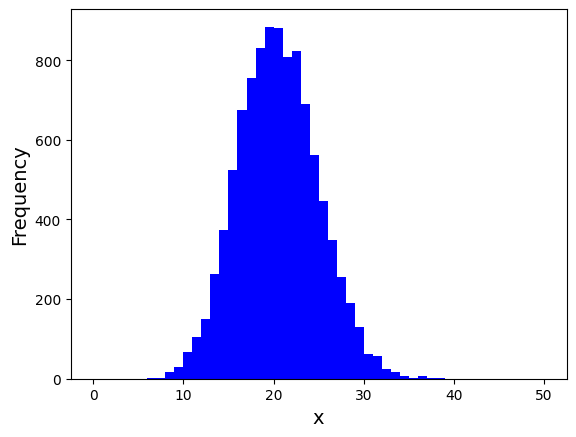

In [ ]:
range_ = (0, 50)
bins = 50

# Plot the histogram
plt.hist(poisson_samples, bins, range_, color='blue', histtype='bar')

# Add labels and title
plt.xlabel(r"x", fontsize=14)
plt.ylabel(r"Frequency", fontsize=14)

# Display the plot
plt.show()

#Integration

When we calculated $\pi$ above, we used our random samples  as a proxy for area - we can use this to integrate any function.

If we generate random samples in a box containing a curve we want to integrate, then the integral is the fraction of points below the curve times the area of the box.

**Example**

Perform the integral:

$F = \int_{-2}^2 (4 - x^2) dx$


In [ ]:
#Define function to be integrated
def f(x):
    return 4 - x**2

#Make it possible for f(x) to evaluate arrays
# f = np.frompyfunc(f, 1, 1)

#Define integration limits
MIN_X = -2
MAX_X = 2

In [ ]:
#Number of random integration points
num_points = 1000

x_rnd_vals = np.random.uniform(MIN_X, MAX_X, size = num_points)
y_rnd_vals = np.random.uniform(0., 4, size = num_points)

area_of_box = (MAX_X - MIN_X) * 4.

#stack the two sets of random numbers to create (x, y) pairs
rnd_vals_2D = np.column_stack((x_rnd_vals, y_rnd_vals))

#the above is achieved more compactly with:
#np.random.uniform((xmin, ymin), (xmax, ymax), (num_points, 2))

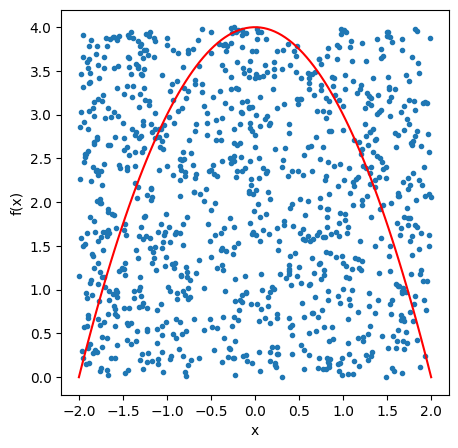

In [ ]:
x_vals = np.linspace(MIN_X, MAX_X, 100)
f_vals = f(x_vals)

fig1, ax = plt.subplots(figsize = (5, 5))
ax.plot(x_vals, f_vals, 'r-')
ax.scatter(rnd_vals_2D[:,0], rnd_vals_2D[:,1], marker='.')

plt.xlabel("x")
plt.ylabel("f(x)")
plt.show()

In [ ]:
num_below = 0

#loop over the array of points and count points below sin(x)
for point in rnd_vals_2D:
    if( point[1] < f(point[0])):
        num_below += 1

print("MC approx F_N = " + format(area_of_box * num_below / rnd_vals_2D[:,1].size))
print("Actual F = " + format(32/3))

MC approx F_N = 10.416
Actual F = 10.666666666666666


This simple method is not very efficient (we throw away samples) and it doesn't (easily) account for regions where the integral goes negative. We also may not a priori know what the maximum of f(x) is (so it will be more inefficient).

Instead lets revisit the very basic approximation of an integral as a sum of rectangles:

$\int f(x) dx \approx \sum_i f(x_i) \Delta x_i$

We can perform $N$ random samples of $f(x)$ and assign an average 'width' to each sample $\Delta x = (x_{\rm{max}} - x_{\rm{min}})/N$

Giving the Monte Carlo estimator:

$F_N = \frac{x_{\rm{max}} - x_{\rm{min}}}{N}\sum_{i=1}^N f(x_i)$

Implementing this for the above integral, with the same number of points:


In [ ]:
F_N = sum(f(x_rnd_vals)) * (MAX_X-MIN_X) / num_points

print("MC approx F_N = " + format(F_N))
print("Actual F = " + format(32/3))

MC approx F_N = 10.392115896452331
Actual F = 10.666666666666666


## Importance sampling

How are the above methods any better than using a uniform sampling grid?

It's not (in 1D).

But we can transform the above and sample from a non-uniform distribution, instead focusing on regions where the integral is large - this is known as 'importance sampling'.

If we instead draw random samples from a distribution $p(x)$, then we are effectively integrating the weighted integral:

$F  = \int f(x) p(x) dx$

The MC estimator becomes (see more details [here](https://www.pbr-book.org/3ed-2018/Monte_Carlo_Integration/The_Monte_Carlo_Estimator)):

$F_N = \frac{1}{N}\sum_{i=1}^N \frac{f(x_i)}{p(x_i)}$

We want to pick a distribution that is similar to the shape of $f(x)$. To be effective (i.e. perform better than uniform sampling) $p(x)$ needs to have 'fatter tails' than $f(x)$.

Let's start with a normal distribution, since we can easily change the width and get random samples.

In [ ]:
#Generate random normal values
x_samples = np.random.normal( 0, .8, size=num_points)
#only keep those within bounds of integral
x_samples = x_samples[(x_samples >= MIN_X) & (x_samples <= MAX_X)]

F_N_importance = sum(f(x_samples) / norm.pdf(x_samples, scale=.8)) / len(x_samples)

print("MC approx F_N = " + format(F_N))
print("Importance F_N = " + format(F_N_importance))
print("Actual F = " + format(32/3))

MC approx F_N = 10.392115896452331
Importance F_N = 10.75027060103648
Actual F = 10.666666666666666


In [ ]:
#Generate samples in normal distribution with width sigma
sigma = 1
x_samples = np.random.normal( 0, sigma, size=num_points)

#Restrict our samples to be from the interval
x_samples = x_samples[(x_samples >= MIN_X) & (x_samples <= MAX_X)]

#Normalise our normal distribution to the interval
factor = 1-2*norm.cdf(MIN_X, scale=sigma) #this only works because |MIN_X| = |MAX_X|

F_N_importance = sum(f(x_samples) / (norm.pdf(x_samples, scale=sigma)/factor) ) / len(x_samples)

print("MC approx F_N = " + format(F_N))
print("Importance F_N = " + format(F_N_importance))
print("Actual F = " + format(32/3))

MC approx F_N = 10.392115896452331
Importance F_N = 10.722926783221698
Actual F = 10.666666666666666


**Exercise**

If you perform this MC integral many times you will find that the error in the result is smaller than the previous methods - show this as a function of the number of samples. Play around with the width of the normal distribution to see how it affects the error.

MC decreases as $\sqrt(N)$, which is worse than standard integration techniques, however, this is independent of number of dimensions, where standard integration techniques scale exponentially. So in higher-dimensions MC can become the only viable option.

In [ ]:
#SOLUTION (relys on definitions above)

def eval_F_N(num_points):
  x_samples = np.random.uniform(MIN_X, MAX_X, size = num_points)
  return sum(f(x_samples)) * (MAX_X-MIN_X) / num_points

def eval_F_N_importance(num_points, sigma):
  sigma = 1
  x_samples = np.random.normal( 0, sigma, size=num_points)

  #Restrict our samples to be from the interval
  x_samples = x_samples[(x_samples >= MIN_X) & (x_samples <= MAX_X)]

  #Normalise our normal distribution to the interval
  factor = 1-2*norm.cdf(MIN_X, scale=sigma) #this only works because |MIN_X| = |MAX_X|

  return (sum(f(x_samples) / (norm.pdf(x_samples, scale=sigma)/factor) ) / len(x_samples))

eval_F_N = np.frompyfunc(eval_F_N, 1, 1)
eval_F_N_importance = np.frompyfunc(eval_F_N_importance, 2, 1)

In [ ]:
#Do the calculation

for i in range(2):

  F_N_vals = eval_F_N(10**i)
  print(F_N_vals)
# F_N_vals_importance = eval_F_N_importance(n_vals,.5)

NameError: name 'eval_F_N' is not defined

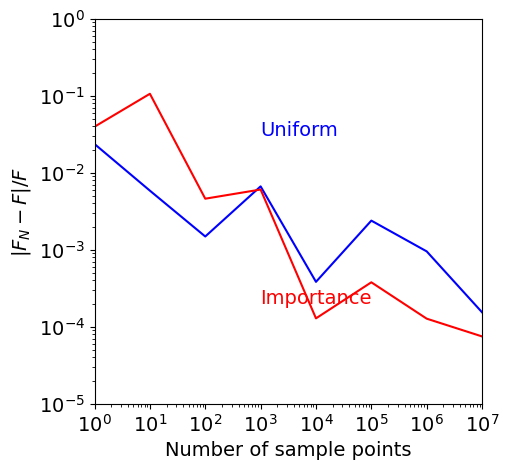

In [ ]:
#Plot the result

fig1 = plt.figure(figsize=(5,5))
plt.plot(n_vals, np.abs(F_N_vals-(32./3))/(32./3), 'b-',
         n_vals, np.abs(F_N_vals_importance-(32./3))/(32./3), 'r-')

plt.yscale('log')
plt.xscale('log')

plt.xlabel(r"Number of sample points",fontsize=14)
plt.ylabel(r"$\vert F_N - F\vert/F$",fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.ylim(1e-5,1)
plt.xlim(1,1e7)

#Add text to label curve
plt.text(1e3, 3e-2,r"Uniform",   fontsize=14, color='blue')
plt.text(1e3, 2e-4,r"Importance",fontsize=14, color='red')
plt.show()

### Metropolis-Hastings for integration

The ultimate distribution to sample from is f(x) itself, therefore we should be able to use the Markov-chain to evaluate the integral.

But wait a second.. we need to evaluate

$F_N = \frac{1}{N}\sum_{i=1}^N \frac{f(x_i)}{p(x_i)}$

where $p(x)$ is a (normalised) pdf of shape $f(x)$. So we would need to know the result of the integral to compute the integral..

That may sound like bad news, but it is possible to iteratively use an approximation to the integral to normalise the sampling distribution. There are many adaptive MC methods that do things like this. A popular version of this scheme is implemented by the VEGAS algorithm.

**Example**

As a basic demonstration of how this works, we can use our Metropolis-Hastings MCMC algorithm to sample the distribution f.

In [ ]:
#Implement MCMC

num_steps = 1000000
step_size = .1
burn_in_steps = 1000

#Setup chain
steps = np.empty(num_steps + burn_in_steps)
steps[0] = 0

#Iterate
for i in range(1,num_steps + burn_in_steps):

    #calculate proposed step
    rnd_step = steps[i-1] + random.normal( 0, step_size)

    #If step is not accepted, repeat
    while f(rnd_step)/f(steps[i-1]) < random.uniform(0,1) or rnd_step < MIN_X or rnd_step > MAX_X:
        #calculate another proposed step
        rnd_step = steps[i-1] + random.normal( 0, step_size)

    #add step to the chain
    steps[i] =  rnd_step

steps = np.delete(steps,range(0,burn_in_steps))

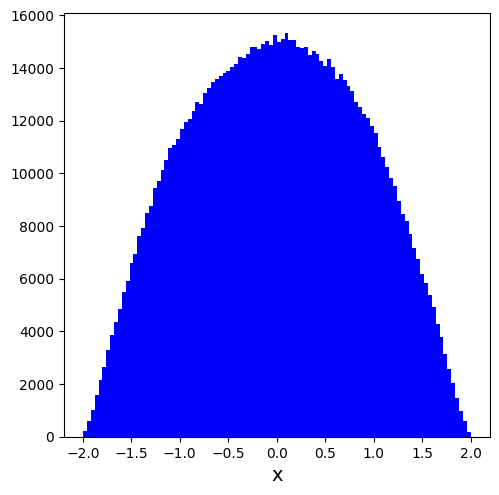

In [ ]:
#Plot a histogram of the chain
fig, ax = plt.subplots(figsize=(5.5, 5.5))
ax.hist(steps, 100, color='blue', histtype='bar')

plt.xlabel(r"x",fontsize=14)
plt.show()

We can approximate the integral by breaking it up into $j$ bins, $b_j$, and treating them as a series of uniformally sampled integrals:

$\int f(x) dx = \sum_{j} \int_{b_j} f(x) dx$

$\approx \sum_{j} \frac{d_j}{N_j}\sum_i f(x_i)$

Where there are $N_j$ samples in the $j$th bin, with width $d_j$.

In [ ]:
#Setup bins
num_bins = 1000
bin_width = (MAX_X - MIN_X) / num_bins

F_N_MCMC = 0
#loop over each bin
for j in range(0,num_bins):

    #grab the samples from the chain that are within each bin
    bin_steps = steps[(steps >= MIN_X + j*bin_width) & (steps <= MIN_X+(j+1)*bin_width)]

    #calculate the value of the integral for that bin
    if( len(bin_steps) > 0 ):
        F_N_MCMC += bin_width * sum(f(bin_steps)) / len(bin_steps)

print(F_N_MCMC)
print("MC approx  F_N = " + format(F_N))
print("Importance F_N = " + format(F_N_importance))
print("MCMC       F_N = " + format(F_N_MCMC))
print("Actual       F = " + format(32/3))

10.666757785453612
MC approx  F_N = 10.392115896452331
Importance F_N = 10.722926783221698
MCMC       F_N = 10.666757785453612
Actual       F = 10.666666666666666


**Exercise**

Add the MC method to the error plot from above

In [ ]:
#SOLUTION

def eval_F_N_MCMC(steps, num_points):
  steps_local = steps[:num_points]
  num_bins = 2000
  bin_width = (MAX_X - MIN_X) / num_bins

  F_N=0
  #loop over each bin
  for j in range(0, num_bins):

    #grab the samples from the chain that are within each bin
    bin_steps = steps_local[(steps_local >= MIN_X + j*bin_width) & (steps_local <= MIN_X+(j+1)*bin_width)]

    #calculate the value of the integral for that bin
    if( len(bin_steps) > 0 ):
        F_N += bin_width * sum(f(bin_steps)) / len(bin_steps)

  return(F_N)

#eval_F_N_MCMC = np.frompyfunc(eval_F_N_MCMC, 2, 1)

In [ ]:
#Calculate integral for a the series of numPoints
F_N_vals_MCMC = np.array([ eval_F_N_MCMC(steps, 10**i) for i in [0,1,2,3,4,5,6,7] ])

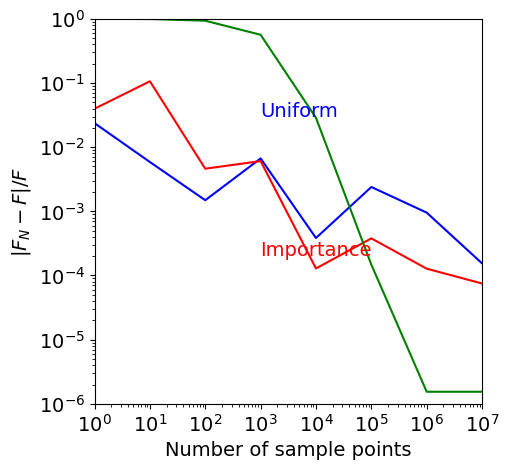

In [ ]:
#Add to the plot

fig1 = plt.figure(figsize=(5,5))
plt.plot(n_vals, np.abs(F_N_vals-(32./3))/(32./3), 'b-',
         n_vals, np.abs(F_N_vals_importance-(32./3))/(32./3), 'r-',
         n_vals, np.abs(F_N_vals_MCMC-(32./3))/(32./3), 'g-')

plt.yscale('log')
plt.xscale('log')

plt.xlabel(r"Number of sample points",fontsize=14)
plt.ylabel(r"$\vert F_N - F\vert/F$",fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.ylim(1e-6,1)
plt.xlim(1,1e7)

#Add text to label curve
plt.text(1e3, 3e-2,r"Uniform",   fontsize=14, color='blue')
plt.text(1e3, 2e-4,r"Importance",fontsize=14, color='red')
plt.show()


**Exercise**

Repeat the above integration methods for another function e.g.:

$f(x) = \sin(x)$

Integrate from $x = 0$ to $\pi$

### VEGAS

In practice you don't have to write your own integrator, smarter optimised methods have been written for you. While there are newer versions of MC integrators, VEGAS is still a popular choice and is available in python.

In [ ]:
!pip install vegas

import vegas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 16.9 MB/s eta 0:00:00


Example in 4D from [the docs](https://vegas.readthedocs.io/en/latest/tutorial.html):

$F = C \int dx_0 \int dx_1 \int dx_2 \int dx_3 e^{-100 \sum_d (x_d - 0.5)^2}$

Where C is chosen so that F = 1


In [ ]:
def f(x):
    dx2 = 0
    for d in range(4):
        dx2 += (x[d] - 0.5) ** 2
    return np.exp(-dx2 * 100.) * 1013.2118364296088

integ = vegas.Integrator([[-1, 1], [0, 1], [0, 1], [0, 1]])

result = integ(f, nitn=10, neval=1000)

print(result.summary())
print('result = %s    Q = %.2f' % (result, result.Q))

itn   integral        wgt average     chi2/dof        Q
-------------------------------------------------------
  1   0.65(29)        0.65(29)            0.00     1.00
  2   1.20(15)        1.09(13)            2.84     0.09
  3   0.944(76)       0.978(66)           1.85     0.16
  4   0.965(50)       0.970(40)           1.24     0.29
  5   1.071(35)       1.028(26)           1.84     0.12
  6   1.016(23)       1.021(17)           1.50     0.19
  7   0.967(18)       0.995(13)           2.01     0.06
  8   0.997(16)       0.9962(98)          1.72     0.10
  9   0.996(13)       0.9962(78)          1.51     0.15
 10   1.027(11)       1.0072(63)          1.96     0.04

result = 1.0072(63)    Q = 0.04
